In [1]:
%load_ext autoreload
%autoreload 2

import gc

import os
import sys
import pandas as pd
import numpy as np
import tqdm
import seaborn as sns
from pathlib import Path
import plotly.express as px

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, TimeSeriesSplit
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score

import catboost as cb
import lightgbm as lgb

pd.set_option('display.max_columns', None)

# если у вас есть CUDA, то она понадобится там для экспериментов в catboost
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

sys.path.append('../')

In [2]:
RANDOM_SEED = 42

In [3]:
TRAIN_TRANSACTIONS_PATH = '../train_transactions_contest/'
TEST_TRANSACTIONS_PATH = '../test_transactions_contest/'

TRAIN_TARGET_PATH = '../train_target.csv'

In [4]:
from utils import read_parquet_dataset_from_local

In [5]:
transactions_frame = read_parquet_dataset_from_local(TRAIN_TRANSACTIONS_PATH, start_from=0, num_parts_to_read=1)

memory_usage_of_frame = transactions_frame.memory_usage(index=True).sum() / 10**9
expected_memory_usage = memory_usage_of_frame * 50
print(f'Объем памяти в  RAM одной партиции данных с транзакциями: {round(memory_usage_of_frame, 3)} Gb')
print(f'Ожидаемый размер в RAM всего датасета: {round(expected_memory_usage, 3)} Gb')

Reading dataset with pandas:   0%|          | 0/1 [00:00<?, ?it/s]

Объем памяти в  RAM одной партиции данных с транзакциями: 0.476 Gb
Ожидаемый размер в RAM всего датасета: 23.798 Gb


## Analyse one parquet

In [9]:
features = transactions_frame.columns

In [28]:
def process(x):
    return x.values.transpose()[:, -2:].tolist()

In [41]:
frame_of_sequences = transactions_frame\
            .sort_values(['app_id', 'transaction_number'])\
            .groupby(['app_id'])[features]\
            .apply(lambda x: process(x))\
            .reset_index()\
            .rename(columns={0: 'sequence'})

## Target

In [23]:
targets = pd.read_csv(TRAIN_TARGET_PATH)
targets.loc[targets.flag == 1].head()

,app_id,product,flag
77,79,0,1
82,85,2,1
197,205,0,1
243,255,2,1
259,274,2,1


* we have inbalanced classes, as consequence, we should make `downsample the majority class` with differennt coeff 
* we have ordered rows by date

2.8 %


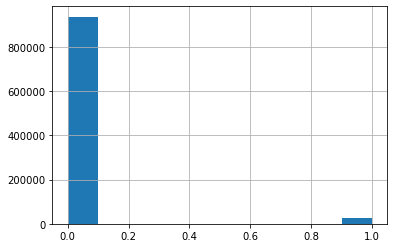

In [7]:
targets.flag.hist();

print(f'{targets.flag.value_counts()[1]/targets.flag.value_counts()[0]*100:.1f} %')

* label distribution

In [27]:
id_range = 100000
st = 0
while(st<targets.shape[0]):
    temp = targets[st:st+id_range] 
    print(f'{temp.flag.value_counts()[1]/temp.flag.value_counts()[0]*100:.1f} %')
    st+=id_range

2.4 %
2.3 %
2.5 %
2.5 %
2.8 %
2.9 %
3.2 %
3.4 %
3.3 %
3.0 %


## Feature engineering
* make feature engineerings using all the data examples without downsample 

#### Simple feature engineering

In [198]:
def FeatureEngineering(frame) -> pd.DataFrame:
    """
    first cycle simple feature engineering 
    :param frame: pd.DataFrame transactions
    """
    feature_frame = pd.DataFrame(index=frame.app_id.unique())
    feature_frame['app_id'] = frame.app_id.unique()
    
    # apply agg function
    drop_columns = ['app_id', 'amnt', 'day_of_week', 'hour', 'days_before', 'weekofyear', 'hour_diff', 'transaction_number']
    COLUMNS = frame.columns.drop(drop_columns)
    agg_func = ['min', 'max', 'nunique']
    for col in COLUMNS:
        for ag_f in agg_func:
            feature_frame[col+'_'+ag_f] = frame.groupby('app_id')[col].aggregate(func=ag_f).values
    
    # find the most frequent value and density
    for col in COLUMNS:
        temp = frame.groupby(['app_id', col])['transaction_number'].agg('count')
        temp = temp.groupby(['app_id']).apply(lambda x: x.sort_values(ascending=False))
        feature_frame[col+'_most_freq_val'] = temp.reset_index(level=[2]).groupby(['app_id'])[col].agg('first').values
        feature_frame[col+'_density'] = temp.groupby(['app_id']).apply(lambda x: list(x)[0]/sum(list(x))).values
        # add density
    
    
    feature_frame['transaction_number_cnt'] = frame.groupby(['app_id'])['transaction_number'].agg('count')
    
    # time features
    # - find k quantiles of hour_diff distribution
    k = 10; q_list = [round(t*0.1,1) for t in range(1,k)]
    temp1 = transactions_frame.groupby(['app_id'])['hour_diff'].apply(lambda x: x.quantile(q_list))
    temp2 = temp1.reset_index()
    temp3 = pd.pivot(temp2,
               values='hour_diff',
               columns=['level_1'],
               index=['app_id'])
    temp3.rename(lambda x: str(x), axis=1, inplace=True)
    feature_frame = feature_frame.join(temp3)
    
    aggs = {
        'amnt': ['mean', 'median', 'sum', 'std'],
        'hour_diff': ['max', 'mean', 'median', 'var', 'std'],
        'days_before': ['min', 'max', 'median']
    }
    
    num_stats = frame.groupby(['app_id']).agg(aggs)
    num_stats.columns = [k + '_' + agg for k in aggs.keys() for agg in aggs[k]]
    
    # amnt features 
    AMNT_COLUMNS = ['operation_type_group', 'ecommerce_flag', 'payment_system', 'income_flag', 'mcc_category', 'operation_type']
    agg_funcs = ['mean', 'count']
    
    pivot_tables = []
    for col in AMNT_COLUMNS:
        aggs = pd.pivot_table(frame, values='amnt',
                          index=['app_id'], columns=[col],
                          aggfunc={'amnt': agg_funcs},
                          fill_value=0.0)
        aggs.columns = [f'{coli[0]}_{col}_{coli[1]}' for coli in aggs.columns.values]
        pivot_tables.append(aggs)
    pivot_tables = pd.concat(pivot_tables, axis=1)
    
    return pd.concat([feature_frame, num_stats, pivot_tables], axis=1)

In [202]:
#transactions_frame.loc[transactions_frame.app_id == 0]
#px.scatter(transactions_frame.loc[transactions_frame.app_id == 80].hour_diff)

In [199]:
%%time
feature_frame = FeatureEngineering(transactions_frame)

CPU times: user 1min 37s, sys: 647 ms, total: 1min 37s
Wall time: 1min 37s


In [200]:
feature_frame

,app_id,currency_min,currency_max,currency_nunique,operation_kind_min,operation_kind_max,operation_kind_nunique,card_type_min,card_type_max,card_type_nunique,operation_type_min,operation_type_max,operation_type_nunique,operation_type_group_min,operation_type_group_max,operation_type_group_nunique,ecommerce_flag_min,ecommerce_flag_max,ecommerce_flag_nunique,payment_system_min,payment_system_max,payment_system_nunique,income_flag_min,income_flag_max,income_flag_nunique,mcc_min,mcc_max,mcc_nunique,country_min,country_max,country_nunique,city_min,city_max,city_nunique,mcc_category_min,mcc_category_max,mcc_category_nunique,currency_most_freq_val,currency_density,operation_kind_most_freq_val,operation_kind_density,card_type_most_freq_val,card_type_density,operation_type_most_freq_val,operation_type_density,operation_type_group_most_freq_val,operation_type_group_density,ecommerce_flag_most_freq_val,ecommerce_flag_density,payment_system_most_freq_val,payment_system_density,income_flag_most_freq_val,income_flag_density,mcc_most_freq_val,mcc_density,country_most_freq_val,country_density,city_most_freq_val,city_density,mcc_category_most_freq_val,mcc_category_density,transaction_number_cnt,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,amnt_mean,amnt_median,amnt_sum,amnt_std,hour_diff_max,hour_diff_mean,hour_diff_median,hour_diff_var,hour_diff_std,days_before_min,days_before_max,days_before_median,count_operation_type_group_1,count_operation_type_group_2,count_operation_type_group_3,mean_operation_type_group_1,mean_operation_type_group_2,mean_operation_type_group_3,count_ecommerce_flag_1,count_ecommerce_flag_2,count_ecommerce_flag_3,mean_ecommerce_flag_1,mean_ecommerce_flag_2,mean_ecommerce_flag_3,count_payment_system_1,count_payment_system_2,count_payment_system_3,count_payment_system_4,count_payment_system_6,count_payment_system_7,mean_payment_system_1,mean_payment_system_2,mean_payment_system_3,mean_payment_system_4,mean_payment_system_6,mean_payment_system_7,count_income_flag_1,count_income_flag_2,count_income_flag_3,mean_income_flag_1,mean_income_flag_2,mean_income_flag_3,count_mcc_category_1,count_mcc_category_2,count_mcc_category_3,count_mcc_category_4,count_mcc_category_5,count_mcc_category_6,count_mcc_category_7,count_mcc_category_8,count_mcc_category_9,count_mcc_category_10,count_mcc_category_11,count_mcc_category_12,count_mcc_category_13,count_mcc_category_14,count_mcc_category_15,count_mcc_category_16,count_mcc_category_17,count_mcc_category_18,count_mcc_category_19,count_mcc_category_20,count_mcc_category_21,count_mcc_category_22,count_mcc_category_23,count_mcc_category_24,count_mcc_category_25,count_mcc_category_26,count_mcc_category_27,count_mcc_category_28,mean_mcc_category_1,mean_mcc_category_2,mean_mcc_category_3,mean_mcc_category_4,mean_mcc_category_5,mean_mcc_category_6,mean_mcc_category_7,mean_mcc_category_8,mean_mcc_category_9,mean_mcc_category_10,mean_mcc_category_11,mean_mcc_category_12,mean_mcc_category_13,mean_mcc_category_14,mean_mcc_category_15,mean_mcc_category_16,mean_mcc_category_17,mean_mcc_category_18,mean_mcc_category_19,mean_mcc_category_20,mean_mcc_category_21,mean_mcc_category_22,mean_mcc_category_23,mean_mcc_category_24,mean_mcc_category_25,mean_mcc_category_26,mean_mcc_category_27,mean_mcc_category_28,count_operation_type_1,count_operation_type_2,count_operation_type_3,count_operation_type_4,count_operation_type_5,count_operation_type_6,count_operation_type_7,count_operation_type_8,count_operation_type_9,count_operation_type_10,count_operation_type_11,count_operation_type_13,count_operation_type_14,count_operation_type_15,count_operation_type_16,count_operation_type_17,count_operation_type_19,count_operation_type_20,count_operation_type_21,count_operation_type_22,mean_operation_type_1,mean_operation_type_2,mean_operation_type_3,mean_operation_type_4,mean_operation_type_5,mean_operation_type_6,mean_operation_type_7,mean_operation_type_8,mean_operation_type_9,mean_operation_type_10,mean_operation_type_11,mean_ope

In [126]:
def prepare_transactions_dataset(path_to_dataset: str, 
                                 num_parts_to_preprocess_at_once: int = 1, 
                                 num_parts_total: int=50, 
                                 save_to_path=None, 
                                 verbose: bool=False):
    """
    return preprocessed pd.DataFrame with generated features
    path_to_dataset: str  
        путь до датасета с партициями
    num_parts_to_preprocess_at_once: int 
        количество партиций, которые будут одновременно держаться в памяти и обрабатываться
    num_parts_total: int 
        общее количество партиций, которые нужно обработать
    save_to_path: str
        путь до папки, в которой будет сохранен каждый обработанный блок в .parquet формате. Если None, то не будет сохранен 
    verbose: bool
        логирует каждый обрабатываемый кусок данных
    """
    preprocessed_frames = []
    block = 0
    for step in tqdm.tqdm_notebook(range(0, num_parts_total, num_parts_to_preprocess_at_once), 
                                   desc="Transforming transactions data"):
        transactions_frame = read_parquet_dataset_from_local(path_to_dataset, step, num_parts_to_preprocess_at_once, 
                                                             verbose=verbose)
        feature_frame = FeatureEngineering(transactions_frame)
        
        if save_to_path:
            block_as_str = str(block)
            if len(block_as_str) == 1:
                block_as_str = '00' + block_as_str
            else:
                block_as_str = '0' + block_as_str
            feature_frame.to_parquet(os.path.join(save_to_path, f'processed_chunk_{block_as_str}.parquet'))
            block +=1
            
        preprocessed_frames.append(feature_frame)
    return pd.concat(preprocessed_frames)

In [203]:
! rm -r ../preprocessed_transactions/
! mkdir ../preprocessed_transactions/

In [204]:
data = prepare_transactions_dataset(TRAIN_TRANSACTIONS_PATH, num_parts_to_preprocess_at_once=2, num_parts_total=50, 
                                    save_to_path='../preprocessed_transactions/')

/tmp/ipykernel_17735/126655560.py:21: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Transforming transactions data:   0%|          | 0/25 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

## pretraining manipulation 

## read from local

In [6]:
data_dir = Path('../preprocessed_transactions/')
data = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir.glob('*.parquet')
)

In [ ]:
data_dir = Path('../preprocessed_test_transactions/')
test_data = pd.concat(
    pd.read_parquet(parquet_file)
    for parquet_file in data_dir.glob('*.parquet')
)

In [7]:
targets = pd.read_csv(TRAIN_TARGET_PATH)
merged_data = data.merge(targets[['app_id', 'product', 'flag']], on=['app_id'])
features = [x for x in merged_data.columns if x not in ['app_id', 'flag']]

## train using all features

In [8]:
targets = merged_data.flag.values

cv = KFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)

oof = np.zeros(len(merged_data))
train_preds = np.zeros(len(merged_data))

models = []

tree_params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'reg_lambda': .0,
    'num_leaves': 8,
    'n_jobs': 4,
    'n_estimators': 1500
}

for fold_, (train_idx, val_idx) in enumerate(cv.split(merged_data, targets), 1):
    print(f'Training with fold {fold_} started.')
    lgb_model = lgb.LGBMClassifier(**tree_params)
    train, val = merged_data.iloc[train_idx], merged_data.iloc[val_idx]
    
    lgb_model.fit(train[features], train.flag.values, eval_set=[(val[features], val.flag.values)],
              early_stopping_rounds=50, verbose=50)

    
    oof[val_idx] = lgb_model.predict_proba(val[features])[:, 1]
    train_preds[train_idx] += lgb_model.predict_proba(train[features])[:, 1] / (cv.n_splits-1)
    models.append(lgb_model)
    print(f'Training with fold {fold_} completed.')

Training with fold 1 started.
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.741732
[100]	valid_0's auc: 0.754758
[150]	valid_0's auc: 0.760543
[200]	valid_0's auc: 0.764654
[250]	valid_0's auc: 0.767004
[300]	valid_0's auc: 0.768597
[350]	valid_0's auc: 0.769745
[400]	valid_0's auc: 0.770877
[450]	valid_0's auc: 0.771833
[500]	valid_0's auc: 0.772544
[550]	valid_0's auc: 0.773058
[600]	valid_0's auc: 0.773711
[650]	valid_0's auc: 0.774306
[700]	valid_0's auc: 0.774806
[750]	valid_0's auc: 0.775311
[800]	valid_0's auc: 0.775524
[850]	valid_0's auc: 0.775961
[900]	valid_0's auc: 0.77623
[950]	valid_0's auc: 0.776757
[1000]	valid_0's auc: 0.776999
[1050]	valid_0's auc: 0.777059
[1100]	valid_0's auc: 0.777353
[1150]	valid_0's auc: 0.777583
[1200]	valid_0's auc: 0.777828
[1250]	valid_0's auc: 0.778191
[1300]	valid_0's auc: 0.778398
[1350]	valid_0's auc: 0.77857
[1400]	valid_0's auc: 0.778708
[1450]	valid_0's auc: 0.77896
[1500]	valid_0's auc: 0.779085
Di

In [9]:
'Train roc-auc', roc_auc_score(targets, train_preds), 'CV roc-auc', roc_auc_score(targets, oof)

('Train roc-auc', 0.8480652968145651, 'CV roc-auc', 0.7764176550505821)

## Feature importance

In [10]:
importances = np.zeros(len(features))
for model in models:
    importances += model.feature_importances_ / len(models)

In [11]:
def plot_feature_importance(feature_names, feature_scores, top_feats=None, low_feats=None, title='Importance', x_label='Importance', 
                            y_label='Features'):
    tuples = [(name, round(score, 3)) for name, score in zip(feature_names, feature_scores)]
    if top_feats is not None:
        tuples = sorted(tuples, key=lambda x: x[1])[-top_feats:]
    elif low_feats is not None:
        tuples = sorted(tuples, key=lambda x: x[1])[:low_feats]
    else: 
        return False
    
    labels, values = zip(*tuples)
    _, ax = plt.subplots(1, 1, figsize=(10, 8))
    ylocs = np.arange(len(values))
    
    ax.barh(ylocs, values, align='center', height=0.4)
    for x, y in zip(values, ylocs):
        ax.text(x + 1, y, x, va='center')
        
    ax.set_yticks(ylocs)
    ax.set_yticklabels(labels)
    xlim = (0, max(values) * 1.1)
    ax.set_xlim(xlim)
    ylim = (-1, len(values))
    ax.set_ylim(ylim)
    
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.grid(True)

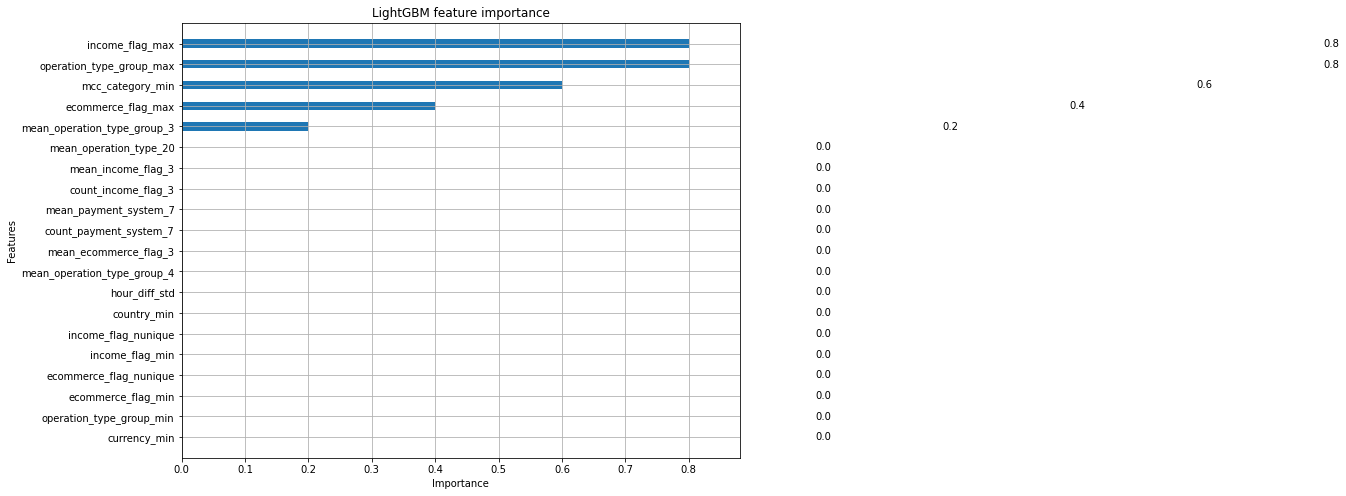

In [12]:
plot_feature_importance(features, importances, low_feats=20, title='LightGBM feature importance', 
                        x_label='Importance')

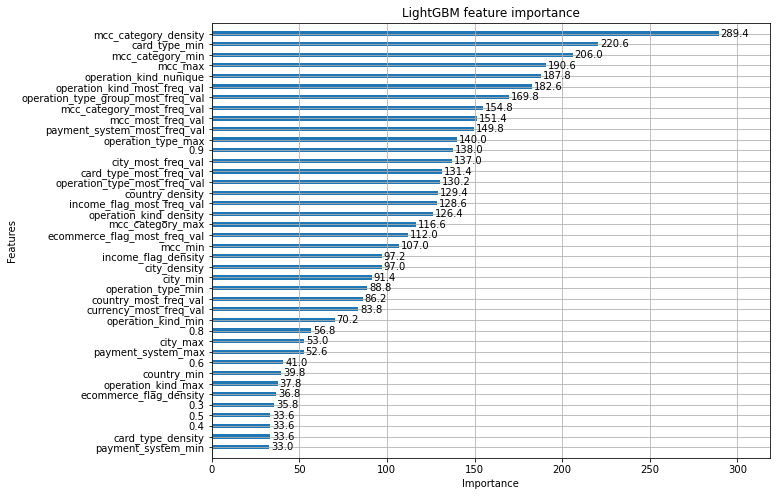

In [165]:
plot_feature_importance(features, importances, top_feats=40, title='LightGBM feature importance', 
                        x_label='Importance')

## select 80% top features by importance

In [44]:
tuples = [(name, round(score, 3)) for name, score in zip(features, importances)]
tuples = sorted(tuples, key=lambda x: x[1])

top_selected_feats = [x[0] for x in tuples if x[1] >= np.quantile(importances, q=0.3)]

In [ ]:
targets = merged_data.flag.values

cv = KFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)

oof = np.zeros(len(merged_data))
train_preds = np.zeros(len(merged_data))

new_models = []

tree_params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'reg_lambda': 0,
    'num_leaves': 16,
    'n_jobs': 5,
    'n_estimators': 1500
}


for fold_, (train_idx, val_idx) in enumerate(cv.split(merged_data, targets), 1):
    print(f'Training with fold {fold_} started.')
    lgb_model = lgb.LGBMClassifier(**tree_params)
    train, val = merged_data.iloc[train_idx], merged_data.iloc[val_idx]
    
    lgb_model.fit(train[top_selected_feats], train.flag.values, eval_set=[(val[top_selected_feats], val.flag.values)],
              early_stopping_rounds=150, verbose=50)

    
    oof[val_idx] = lgb_model.predict_proba(val[top_selected_feats])[:, 1]
    train_preds[train_idx] += lgb_model.predict_proba(train[top_selected_feats])[:, 1] / (cv.n_splits-1)
    new_models.append(lgb_model)
    print(f'Training with fold {fold_} completed.')

Training with fold 1 started.


In [ ]:
'Train roc-auc', roc_auc_score(targets, train_preds), 'CV roc-auc', roc_auc_score(targets, oof)

## Permutation importance

In [28]:
features_ = top_selected_feats
models_ = new_models

permut_importance = np.zeros(len(features_))
cv = KFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)

for fold_, (_, val_idx) in enumerate(cv.split(merged_data, targets), 1):
    print(f'Compute with fold {fold_} started.')
    val = merged_data.iloc[val_idx]
    importances_report = permutation_importance(models_[fold_-1], val[features_], val.flag.values, n_repeats=2, 
                                     n_jobs=4, scoring='roc_auc')
    permut_importance += importances_report.importances_mean / cv.n_splits
    print(f'Computation with fold {fold_} completed.')

Compute with fold 1 started.
Computation with fold 1 completed.
Compute with fold 2 started.
Computation with fold 2 completed.
Compute with fold 3 started.
Computation with fold 3 completed.
Compute with fold 4 started.
Computation with fold 4 completed.
Compute with fold 5 started.
Computation with fold 5 completed.


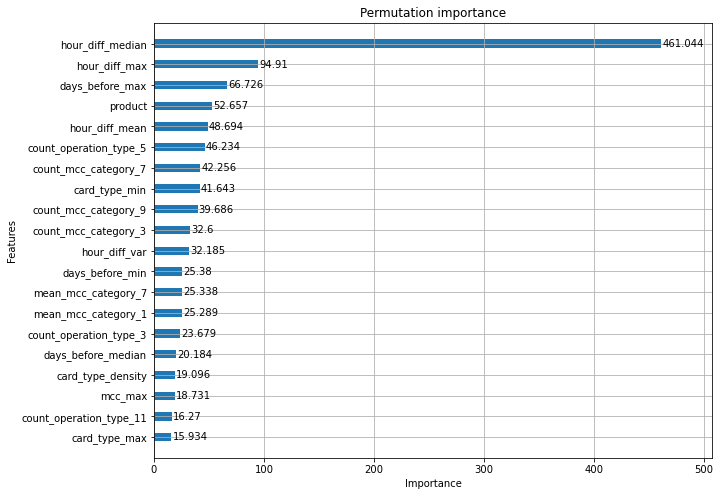

In [33]:
plot_feature_importance(features_, permut_importance*10000, top_feats=20, title='Permutation importance', 
                        x_label='Importance')

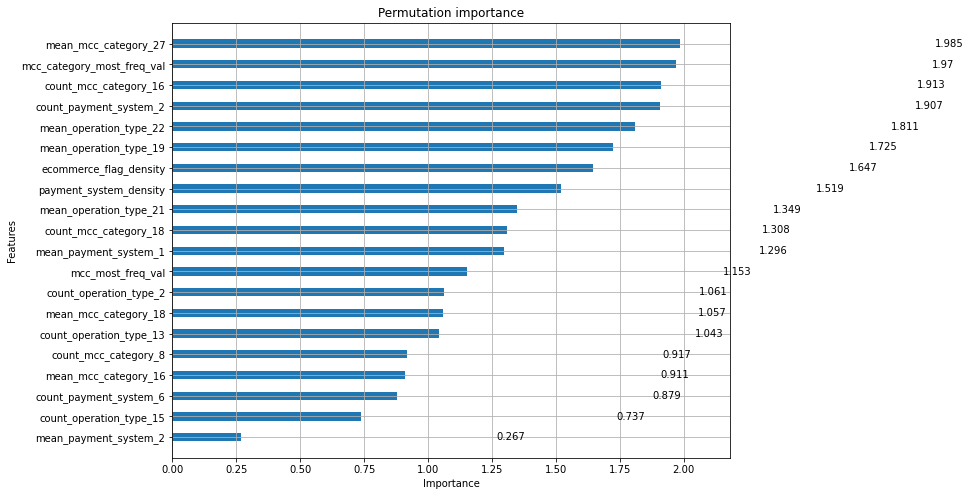

In [34]:
plot_feature_importance(features_, permut_importance*10000, low_feats=20, title='Permutation importance', 
                        x_label='Importance')

## Remove features with low permutation importance

In [39]:
tuples = [(name, round(score, 3)) for name, score in zip(features_, permut_importance)]
tuples = sorted(tuples, key=lambda x: x[1])

top_selected_feats = [x[0] for x in tuples if x[1] > 0]

In [40]:
len(top_selected_feats)

91

In [42]:
targets = merged_data.flag.values

cv = KFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)

oof = np.zeros(len(merged_data))
train_preds = np.zeros(len(merged_data))

new_models = []

tree_params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'reg_lambda': 0,
    'num_leaves': 16,
    'n_jobs': 5,
    'n_estimators': 1500
}


for fold_, (train_idx, val_idx) in enumerate(cv.split(merged_data, targets), 1):
    print(f'Training with fold {fold_} started.')
    lgb_model = lgb.LGBMClassifier(**tree_params)
    train, val = merged_data.iloc[train_idx], merged_data.iloc[val_idx]
    
    lgb_model.fit(train[top_selected_feats], train.flag.values, eval_set=[(val[top_selected_feats], val.flag.values)],
              early_stopping_rounds=50, verbose=50)

    
    oof[val_idx] = lgb_model.predict_proba(val[top_selected_feats])[:, 1]
    train_preds[train_idx] += lgb_model.predict_proba(train[top_selected_feats])[:, 1] / (cv.n_splits-1)
    new_models.append(lgb_model)
    print(f'Training with fold {fold_} completed.')

Training with fold 1 started.
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 0.749296
[100]	valid_0's auc: 0.760621
[150]	valid_0's auc: 0.765869
[200]	valid_0's auc: 0.768938
[250]	valid_0's auc: 0.770425
[300]	valid_0's auc: 0.771945
[350]	valid_0's auc: 0.77271
[400]	valid_0's auc: 0.773167
[450]	valid_0's auc: 0.773843
[500]	valid_0's auc: 0.774399
[550]	valid_0's auc: 0.774841
[600]	valid_0's auc: 0.775019
[650]	valid_0's auc: 0.775548
[700]	valid_0's auc: 0.77583
[750]	valid_0's auc: 0.776049
[800]	valid_0's auc: 0.776114
[850]	valid_0's auc: 0.776319
[900]	valid_0's auc: 0.776575
[950]	valid_0's auc: 0.776591
[1000]	valid_0's auc: 0.776963
[1050]	valid_0's auc: 0.777214
[1100]	valid_0's auc: 0.77748
[1150]	valid_0's auc: 0.777728
[1200]	valid_0's auc: 0.777825
[1250]	valid_0's auc: 0.777861
[1300]	valid_0's auc: 0.777792
Early stopping, best iteration is:
[1266]	valid_0's auc: 0.777952
Training with fold 1 completed.
Training with fold 2 started

In [43]:
'Train roc-auc', roc_auc_score(targets, train_preds), 'CV roc-auc', roc_auc_score(targets, oof)

('Train roc-auc', 0.8742828255086866, 'CV roc-auc', 0.7763679399451383)

## As we can see, we have overfitting -> how to remove this?